# Data Preparation
Data preparation is a crucial step in building machine learning models, as the quality and structure of the data directly impact model performance. In this section, we will focus on cleaning, preprocessing, and splitting the data into training and testing sets.
1. [Data Retrieval](#retrieve)
2. [Data Preprocessing](#preprocess)
3. [Train and Test Split](#split)

## Imports

In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import math

<a id="retrieve"></a>
## 1. Data Retrieval
We use yfinance to download market data from Yahoo! Finance and store the closing prices in a pandas DataFrame to clean the data by removing NA values.

In [24]:
def get_stock(start, end, stock):
    '''
    Return the data as Numpy arrays and incrementing indexes for each value for the time series.

    Parameters:
    -- start: start date "Year-Month-Day"
    -- end: end date "Year-Month-Day"
    -- stock: The label of the stock to download from yahoo stocks
    
    Returns:
    -- df: 1d Numpy array containing all the closing prices from the start to end data except for the last 100 days
    -- index: incrementing indexes for the closing prices
    '''
    
    yfd = yf.download(stock, start=start, end=end)
    df = pd.DataFrame({'Close': yfd['Close']})
    df = df.dropna().reset_index(drop=True)

    df = np.array(df)
    index = np.linspace(1, df.shape[0], df.shape[0])

    return df, index 

Here, we analyze S&P 500 stock prices.

In [25]:
''' Define stocks '''
# [name, start-date, end-date]
stock = ['^GSPC', '1980-01-01', '2024-10-01']
df, index = get_stock(stock[1], stock[2], stock[0])

# TODO:
# 1.) print out the function output and see what the data looks like
# 2.) Look how the function obtained and edited the dataframe
# 3.) Change the date and compare this with the real stock data. How can you pinpoint an exact day?

[*********************100%***********************]  1 of 1 completed


### 1.1 Data Visualization

[[ 105.76000214]
 [ 105.22000122]
 [ 106.51999664]
 ...
 [5745.37011719]
 [5738.16992188]
 [5762.47998047]] (11281, 1)
(11281,) (11281,)


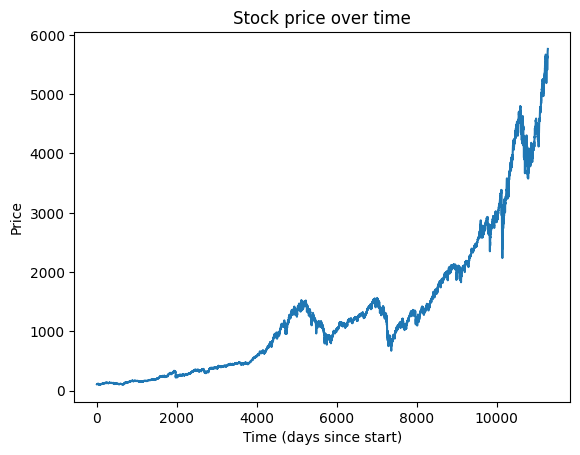

In [20]:
print(df, df.shape)
print(index.shape, df.T[0].shape)

plt.plot(index, df.T[0])
plt.title("Stock price over time")
plt.xlabel('Time (days since start)')
plt.ylabel('Price')
plt.show()

<a id="preprocess"></a>
## 2. Data Preprocessing
In data preprocessing, the stock price data is transformed into a format suitable for model training by constructing 365-day windows of historical closing prices as input features, with the closing price on the 366th day as the target. 


Let $X = [x_1, x_2, ..., x_n]$ represent the sequence of closing prices, where $x_i$ is the closing price at day $i$.

We define the bins (input features) as overlapping windows of size $k = 365$ days: <br>
&emsp; bins = $[X[x_1, x_2, ..., x_{k}], X[x_2, x_3, ..., x_{k + 1}] ... X[x_{n - k - 1}, x_{n - k}, ..., x_{n - 1}]]$ <br>
where each bin $[X[x_i, x_{i+1}, ..., x_{i+k-1}]$ contains $k$ closing prices.

The target $y$ is the closing price on the following day for each corresponding window: <br>
&emsp; $y = [x_2, x_3, ..., x_n]$ <br>
where each $y_i = x_{i+1}$ represents the closing price on the day following the $i$-th window of historical data.

In [ ]:
def bin_data(df, bin_size):
    '''
    Returns the data split into bins of size <bin_size>. The bins are used to predict the day on index <bin_size> + 1.
    
    Parameters:
    -- df: dataset containing the closing prices for the stock
    -- bin_size: size of bins for the data

    Returns:
    -- bins: Numpy array size (len(df) - bin_size, bin_size), bins created based on a sliding window incrementing by 1
    '''
    
    bins = np.array([df[i:i + bin_size].T.reshape(-1) for i in range(0, len(df) - bin_size - 1, 1)])
    return bins 

In [21]:
bin_size = 730 # We require the past year of data
bins = bin_data(df, bin_size)

print(bins.shape)
print(bins[0][:5], bins[0].shape)
print(bins[1][:5], bins[1].shape)
print()
print(bins[-1][-10:])

# TODO
# 1.) Try a different bin size
# 2.) See if you can find the corresponding {y} value

(10550, 730)
[105.76000214 105.22000122 106.51999664 106.80999756 108.94999695] (730,)
[105.22000122 106.51999664 106.80999756 108.94999695 109.05000305] (730,)

[5626.02001953 5633.08984375 5634.58007812 5618.25976562 5713.64013672
 5702.54980469 5718.56982422 5732.93017578 5722.25976562 5745.37011719]


<a id="split"></a>
## 3. Train and Test Split

Data splitting can be performed in various ways, with an 80% training and 20% testing split being the most common approach. The objective is to train the model in a way that minimizes overfitting, which occurs when the model captures noise in the data rather than learning the underlying patterns that generalize to unseen data.

In [ ]:
def split_data(windows, df, index, window_size):
    '''
    Splits data into training and testing sets, maintaining the relationship between bins and targets.

    Parameters:
    -- bins: Numpy array of binned data (features).
    -- df: Original dataset (target values).
    -- index: Corresponding indices of the dataset.
    -- bin_size: Size of the bins (used to offset the target values).

    Returns:
    -- X_train, y_train, X_test, y_test, train_index, test_index, train_size, test_size
    '''
    targets = np.array(df[window_size:]).T.reshape(-1)
    indices = index[window_size:]

    # Use sklearn's train_test_split
    X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(
        windows, targets, indices, test_size=0.2, random_state=42, shuffle=False
    )

    return X_train, y_train, X_test, y_test, train_index, test_index, len(X_train), len(X_test)

In [22]:
X_train, y_train, X_test, y_test, train_index, test_index, train_size, test_size = split_data(bins, df, index, bin_size)

print("train_size:", train_size)
print("test_size:", test_size)
print("x_size:", X_train.shape, X_test.shape)
print("y_size:", y_train.shape, y_test.shape)

# TODO
# 1.) Experiment with different train and test splits by modifying the split_data function.

train_size: 8440
test_size: 2110
x_size: (8440, 730) (2110, 730)
y_size: (8440,) (2110,)
